### 로지스틱 회귀

- 전처리/피처선택/SMOTE가 완료된 train/val 데이터 불러오기
- 로지스틱 회귀 학습 및 예측
- 평가 지표(정확도, 정밀도, 재현율, F1, ROC-AUC, confusion matrix 등)
- 시각화(Confusion Matrix, ROC Curve, Feature Importance 등)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore') 

import platform
import matplotlib.pyplot as plt

# 운영체제에 따라 한글 폰트 설정
system_name = platform.system()

if system_name == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif system_name == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux or unknown
    plt.rcParams['font.family'] = 'NanumGothic'  # 설치되어 있어야 함

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ 한글 폰트 설정 완료: {plt.rcParams['font.family'][0]}")

✅ 한글 폰트 설정 완료: Malgun Gothic


In [15]:
# 📂 데이터 불러오기
train_df = pd.read_csv('../../3_Post-Feature Engineering/JY/train_data_with_smote.csv')
val_df = pd.read_csv('../../3_Post-Feature Engineering/JY/val_data.csv')

In [16]:
# 데이터 분리 함수

def get_X_y(df):
    X = df.drop(columns=['is_defaulted'], errors='ignore')
    y = df['is_defaulted']
    return X, y

X_train, y_train = get_X_y(train_df)
X_val, y_val = get_X_y(val_df)

# 학습/예측/평가 함수
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

def train_and_evaluate_logistic(X_train, y_train, X_val, y_val):
    model = LogisticRegression(max_iter=10000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, y_proba)
    }
    print("✅ 평가 결과:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return model, y_pred, y_proba

model, y_pred, y_proba = train_and_evaluate_logistic(X_train, y_train, X_val, y_val)

✅ 평가 결과:
accuracy: 0.8356
precision: 0.0066
recall: 0.5000
f1: 0.0130
roc_auc: 0.7527


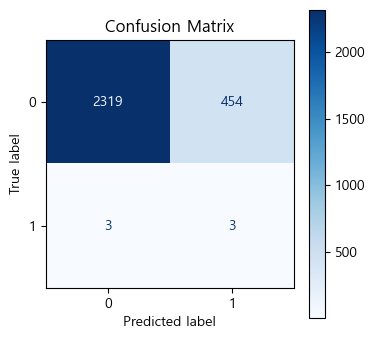

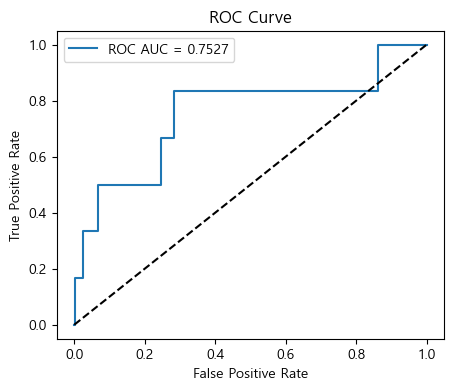

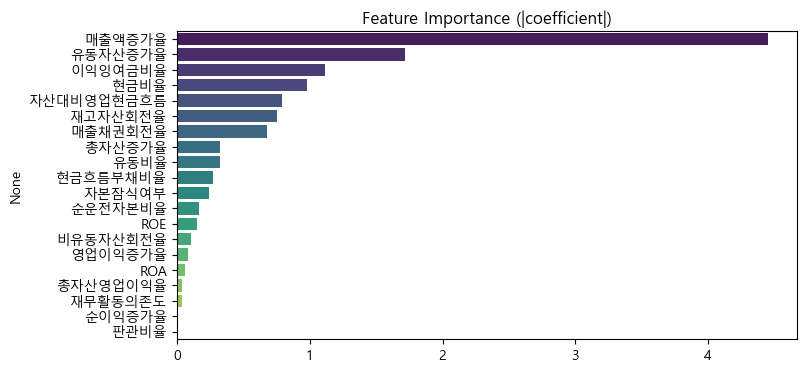

In [17]:
# Confusion Matrix 시각화
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_val, y_proba):.4f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature Importance 시각화
importances = pd.Series(model.coef_[0], index=X_train.columns)
importances = importances.abs().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importance (|coefficient|)')
plt.show()


[Threshold: 0.50] Precision: 0.0052, Recall: 0.6667, F1: 0.0104
Confusion Matrix:
 [[2011  762]
 [   2    4]]

[Threshold: 0.30] Precision: 0.0027, Recall: 1.0000, F1: 0.0054
Confusion Matrix:
 [[ 555 2218]
 [   0    6]]

[Threshold: 0.10] Precision: 0.0022, Recall: 1.0000, F1: 0.0045
Confusion Matrix:
 [[  93 2680]
 [   0    6]]

[Threshold: 0.05] Precision: 0.0022, Recall: 1.0000, F1: 0.0044
Confusion Matrix:
 [[  45 2728]
 [   0    6]]

[Threshold: 0.01] Precision: 0.0022, Recall: 1.0000, F1: 0.0043
Confusion Matrix:
 [[  18 2755]
 [   0    6]]


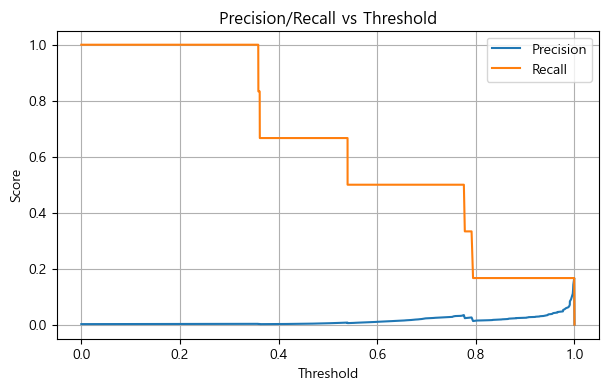

In [12]:
# threshold 조정 함수 및 시각화
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_with_threshold(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n[Threshold: {threshold:.2f}] Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    return precision, recall, f1, cm

# 여러 threshold에 대해 평가
thresholds = [0.5, 0.3, 0.1, 0.05, 0.01]
results = []
for th in thresholds:
    results.append(evaluate_with_threshold(y_val, y_proba, threshold=th))

# Precision-Recall trade-off 시각화
def plot_precision_recall_vs_threshold(y_true, y_proba):
    from sklearn.metrics import precision_recall_curve
    precisions, recalls, ths = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(7,4))
    plt.plot(ths, precisions[:-1], label='Precision')
    plt.plot(ths, recalls[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision/Recall vs Threshold')
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall_vs_threshold(y_val, y_proba)

In [11]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)
logreg = sm.Logit(y_train, X_train_const).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.593498
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           is_defaulted   No. Observations:                27484
Model:                          Logit   Df Residuals:                    27463
Method:                           MLE   Df Model:                           20
Date:                Sat, 21 Jun 2025   Pseudo R-squ.:                  0.1438
Time:                        05:51:03   Log-Likelihood:                -16312.
converged:                       True   LL-Null:                       -19050.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5313      0.019    -27.813      0.000      -0.569      -0.494
유동비율          -0.3147      0.047     -6.669      0.000      -0.407      -0.222
순운전자본비율       -0.0858      0.023     -3.770      0.000      -0.130      -0.041
현금비율          -0.2736      0.034     -7.956      0.000      -0.341      -0.206
현금흐름부채비율      -0.1324      0.022     -6.132      0.000      -0.175      -0.090
자본잠식여부         0.1176      0.011     10.833      0.000       0.096       0.139
총자산증가율         0.0366      0.018      2.072      0.038       0.002       0.071
유동자산증가율       -0.4512      0.037    -12.099      0.000      -0.524      -0.378
매출액증가율        -5.9323      0.462    -12.853      0.000      -6.837      -5.028
순이익증가율        -0.0115      0.019     -0.611      0.541      -0.048       0.025
영업이익증가율        0.0240      0.019      1.262      0.207      -0.013       0.061
자산대비영업현금흐름     0.2363      0.021     11.239      0.000       0.195       0.277
ROE           -0.0502      0.026     -1.947      0.052      -0.101       0.000
ROA           -0.0255      0.023     -1.089      0.276      -0.071       0.020
총자산영업이익율       0.1291      0.024      5.363      0.000       0.082       0.176
이익잉여금비율       -0.6029      0.020    -30.193      0.000      -0.642      -0.564
비유동자산회전율      -0.0973      0.023     -4.247      0.000      -0.142      -0.052
판관비율           0.0088      0.022      0.398      0.690      -0.035       0.052
매출채권회전율       -0.2501      0.168     -1.486      0.137      -0.580       0.080
재고자산회전율       -0.1077      0.147     -0.734      0.463      -0.395       0.180
재무활동의존도       -0.3149      0.062     -5.095      0.000      -0.436      -0.194
==============================================================================
"""